# Classic Regression


## Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR 
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.ensemble import RandomForestRegressor
import xgboost 


sns.set_style('darkgrid')

data_file = './data/model_ready.parquet'
df = pd.read_parquet(data_file, "pyarrow")

# sort index
df = df.sort_index()
# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')

# separte names for inspection
columns = df.columns
load_names = []
wind_names = []
dewpoint_names = []
target_names = []
for col in columns:
    if 'mtlf' in col:
        load_names.append(col)
    if 'ws' in col:
        wind_names.append(col)
    if 'td' in col:
        dewpoint_names.append(col)
    if 'da_energy' in col:
        target_names.append(col)


## Features

As analyzed before, we will add the following features to dataset:
1. detrend target as previously we have shown the target is non stationary
1. time features: sine and cosine pairs of day, bimonth and year
2. add lags of (1,2,5,9) of the targets to the dataset



In [2]:
target = target_names[0]

# add time features
date_time = df.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# the data has obvious daily pattern, bimonth pattern and annual pattern
day = 24*60*60
bimonth = (365.2425/6)*day
year = (365.2425)*day

# use cos/sin as 0 should be close to 23
df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['bimonth_sin'] = np.sin(timestamp_s * (2 * np.pi / bimonth))
df['bimonth_cos'] = np.cos(timestamp_s * (2 * np.pi / bimonth))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))


In [3]:
# we need use current step to predict next step, so we need to shift the target column by 1 step
# or we can do multistep predictions
n_futures = 24
futures = [i for i in range(1, n_futures+1)]
lags = [1]

def make_lags_futures(df, target, lags, futures):
    for lag in lags:
        df[f'{target}_lag_{lag-1}'] = df[target].shift(lag-1)
    for future in futures:
        df[f'{target}_future_{future}'] = df[target].shift(-future)
    df = df.drop(columns = [target])
    return df.dropna()

# drop other targets 
df['target'] = df[target]
df = df.drop(columns=target_names)
df = make_lags_futures(df, 'target', lags, futures)

targets = []
for i in range(n_futures):
    targets.append(f'target_future_{i+1}')

y = df[targets]
X = df.drop(columns=targets)


In [4]:
y.iloc[:, 0]

interval_ending_dt_utc
2019-09-01 00:00:00    20.77
2019-09-01 01:00:00    20.82
2019-09-01 02:00:00    18.43
2019-09-01 03:00:00    18.98
2019-09-01 04:00:00    18.06
                       ...  
2021-08-28 20:00:00    42.89
2021-08-28 21:00:00    43.99
2021-08-28 22:00:00    40.79
2021-08-28 23:00:00    33.92
2021-08-29 00:00:00    33.77
Freq: H, Name: target_future_1, Length: 17473, dtype: float64

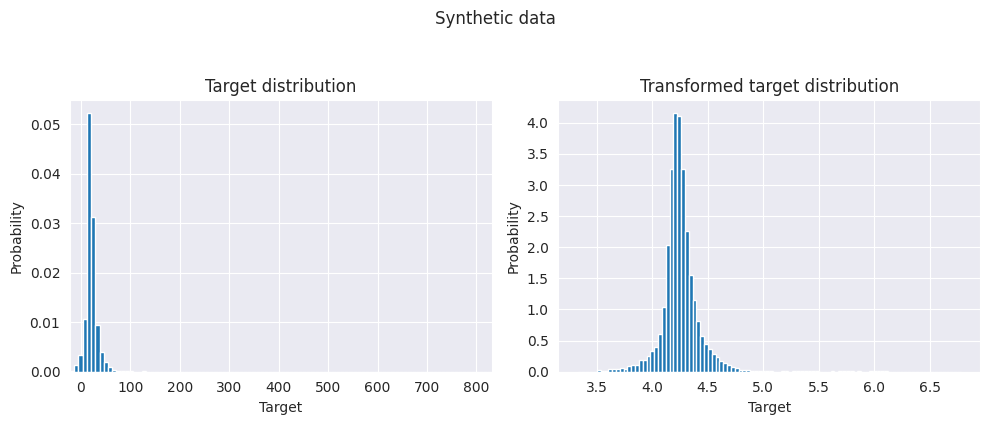

In [5]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
y1 = y.iloc[:, 0]
ax0.hist(y1, bins=100, density=True)
ax0.set_xlim([y1.min(), y1.max()])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

y_trans = np.log(y1+50)
ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

In [6]:
# split train and test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

#y = np.log(y+50)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False, random_state=42)



In [7]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48
)

Xy_splits = list(ts_cv.split(X_train_val, y_train_val))

# check the first split
train_0, val_0 = Xy_splits[0]
X_train_val.iloc[train_0]

,central_mtlf_fc,north_mtlf_fc,south_mtlf_fc,system_mtlf_fc,ia_ksux_ws_mph_fc,il_kmdw_ws_mph_fc,il_kord_ws_mph_fc,mi_kanj_ws_mph_fc,mi_karb_ws_mph_fc,mi_kazo_ws_mph_fc,...,mo_kstl_td_f_fc,oh_kluk_td_f_fc,ok_klaw_td_f_fc,day_sin,day_cos,bimonth_sin,bimonth_cos,year_sin,year_cos,target_lag_0
interval_ending_dt_utc,,,,,,,,,,,,,,,,,,,,,
2019-09-01 00:00:00,39290.0,16050.0,27040.0,82370.0,4.157354,4.023245,3.710326,2.682164,2.816272,1.788109,...,19.277778,19.277778,21.111111,-8.223106e-12,1.000000,-0.038954,0.999241,-0.862760,-0.505613,21.95
2019-09-01 01:00:00,39644.0,15757.0,25871.0,81272.0,4.470273,4.023245,4.470273,2.235136,3.129191,2.235136,...,19.444444,17.777778,21.111111,2.588190e-01,0.965926,-0.034657,0.999399,-0.863122,-0.504995,20.77
2019-09-01 02:00:00,39184.0,15820.0,25163.0,80167.0,4.157354,3.889137,4.157354,1.788109,2.548055,1.922217,...,19.277778,17.388889,21.277778,5.000000e-01,0.866025,-0.030358,0.999539,-0.863484,-0.504376,20.82
2019-09-01 03:00:00,37378.0,15484.0,24112.0,76974.0,3.889137,3.710326,3.889137,1.341082,1.922217,1.654001,...,19.055556,17.055556,21.500000,7.071068e-01,0.707107,-0.026059,0.999660,-0.863845,-0.503757,18.43
2019-09-01 04:00:00,35104.0,14701.0,22690.0,72495.0,3.576218,3.576218,3.576218,0.894055,1.341082,1.341082,...,18.888889,16.666667,21.666667,8.660254e-01,0.500000,-0.021760,0.999763,-0.864206,-0.503138,18.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-11 00:00:00,46830.0,21000.0,20860.0,88690.0,2.995083,4.783192,5.498435,2.995083,5.811354,4.917300,...,-9.611111,-6.111111,-6.666667,-1.062816e-11,1.000000,-0.819845,-0.572585,-0.355462,0.934691,35.31
2019-12-11 01:00:00,46979.0,21117.0,21488.0,89584.0,2.235136,4.470273,4.470273,3.576218,5.811354,4.470273,...,-9.444444,-8.888889,-6.666667,2.588190e-01,0.965926,-0.822300,-0.569054,-0.354792,0.934945,32.02
2019-12-11 02:00:00,46368.0,20832.0,21506.0,88706.0,2.369245,4.336165,4.336165,3.889137,5.230219,4.336165,...,-9.277778,-8.333333,-6.277778,5.000000e-01,0.866025,-0.824740,-0.565512,-0.354122,0.935199,28.92


Text(0.5, 1.0, 'Test distribution')

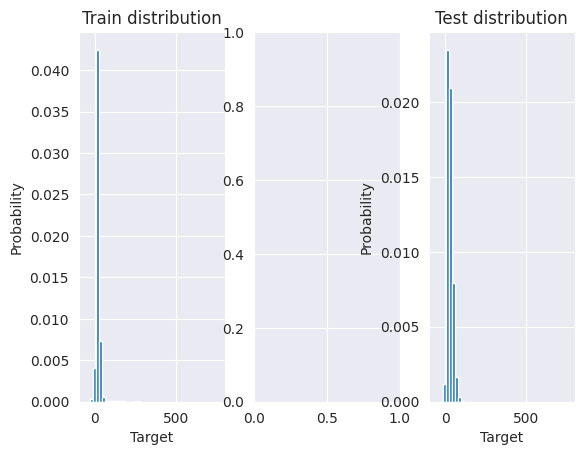

In [8]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3)

ax0.hist(y_train_val.iloc[:,0], bins=50, range=[-100, 800], density=True)
ax0.set_xlim([-100, 800])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Train distribution")

#ax1.hist(y_val, bins=50, range=[y.min(), y.max()], density=True)
#ax1.set_xlim([y.min(), y.max()])
#ax1.set_ylabel("Probability")
#ax1.set_xlabel("Target")
#ax1.set_title("Val distribution")

ax2.hist(y_test.iloc[:, 0], bins=50, range=[-100, 800], density=True)
ax2.set_xlim([-100, 800])
ax2.set_ylabel("Probability")
ax2.set_xlabel("Target")
ax2.set_title("Test distribution")

seems validation and testing distribution is not the similar. Maybe the data from 2021-02 where there are serious shortage of supply in MISO that lead to price spike. 

We probably need remove that data.

## Baseline Model
Use previous step's target as prediction.
For one-step prediction, we use the current step value as prediction for next step. 
This will lead to a flat line in the prediction plot if used for multi-step prediction.

Here we simply use the previous 24-hour value as prediction for next 24-hour.

In [24]:
n_futures = 24

X_cp = X.copy()
y_pred = pd.DataFrame()
for i in range(n_futures):
    y_pred[f'target_future_{i+1}'] = X_cp['target_lag_0'].shift(24-i)

y_test_pred_base = y_pred.iloc[-len(y_test):, :]
# baseline model metrics
mse_test_base = mean_squared_error(y_test, y_test_pred_base)
mae_test_base = mean_absolute_error(y_test, y_test_pred_base)
r2_score_base = r2_score(y_test, y_test_pred_base)
print(f"baseline model metrics: mse: {mse_test_base}, mae: {mae_test_base}, r2: {r2_score_base}")

baseline model metrics: mse: 64.81935194423248, mae: 5.816308501844079, r2: 0.6918126787832423


In [10]:
from sklearn.model_selection import cross_validate

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

## XGB Tree

In [61]:

std_scaler = StandardScaler()
pca = PCA(n_components=0.99, svd_solver='full')
xgb = xgboost.XGBRegressor(
    objective ='reg:squarederror', 
    colsample_bytree = 0.3, 
    learning_rate = 0.1, 
    max_depth = 5, 
    alpha = 1, 
    n_estimators = 100)

xgb_pipe = Pipeline([
    ('std', std_scaler), 
    #('pca', pca),
    ('xgb', xgb)]
    )

param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__n_estimators': [50, 100],
}

gs = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=ts_cv, scoring='neg_mean_absolute_error', n_jobs=10)

dy_train_val = y_train_val.copy()
last_step = X_train_val['target_lag_0']
for i in range(n_futures):
    dy_train_val.iloc[:, i] = y_train_val.iloc[:, i] - last_step
    last_step = y_train_val.iloc[:, i]

gs.fit(X_train_val, dy_train_val)


GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(alpha=1, base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=0.3,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     featur...
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=5,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None, ...))]),
             n_jobs=10,
             param_grid={'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error')

In [62]:
gs.best_params_

{'xgb__max_depth': 7, 'xgb__n_estimators': 100}

In [63]:
# get metrics for train, val and test
dy_train_pred = pd.DataFrame(gs.predict(X_train_val), index = y_train_val.index)
dy_test_pred = pd.DataFrame(gs.predict(X_test), index = y_test.index) 


y_train_pred = dy_train_pred.copy()
last = X_train_val['target_lag_0']
for i in range(n_futures):
    y_train_pred.iloc[:, i] = y_train_pred.iloc[:, i] + last 
    last = y_train_pred.iloc[:, i]

y_test_pred = dy_test_pred.copy()
last = X_test['target_lag_0']
for i in range(n_futures):
    y_test_pred.iloc[:, i] = y_test_pred.iloc[:, i] + last
    last = y_test_pred.iloc[:, i]

mse_train, mae_train, r2_score_train = get_metrics(y_train_val, y_train_pred)
print(f"train metrics: mse: {mse_train}, mae: {mae_train}, r2_score: {r2_score_train}")

mse_test, mae_test, r2_score_test = get_metrics(y_test, y_test_pred)
print(f"test metrics: mse: {mse_test}, mae: {mae_test}, r2_score: {r2_score_test}")

train metrics: mse: 17.447279375358065, mae: 2.903396929827584, r2_score: 0.9760654299145295
test metrics: mse: 89.4769199711691, mae: 6.740001398040697, r2_score: 0.5745299043745818


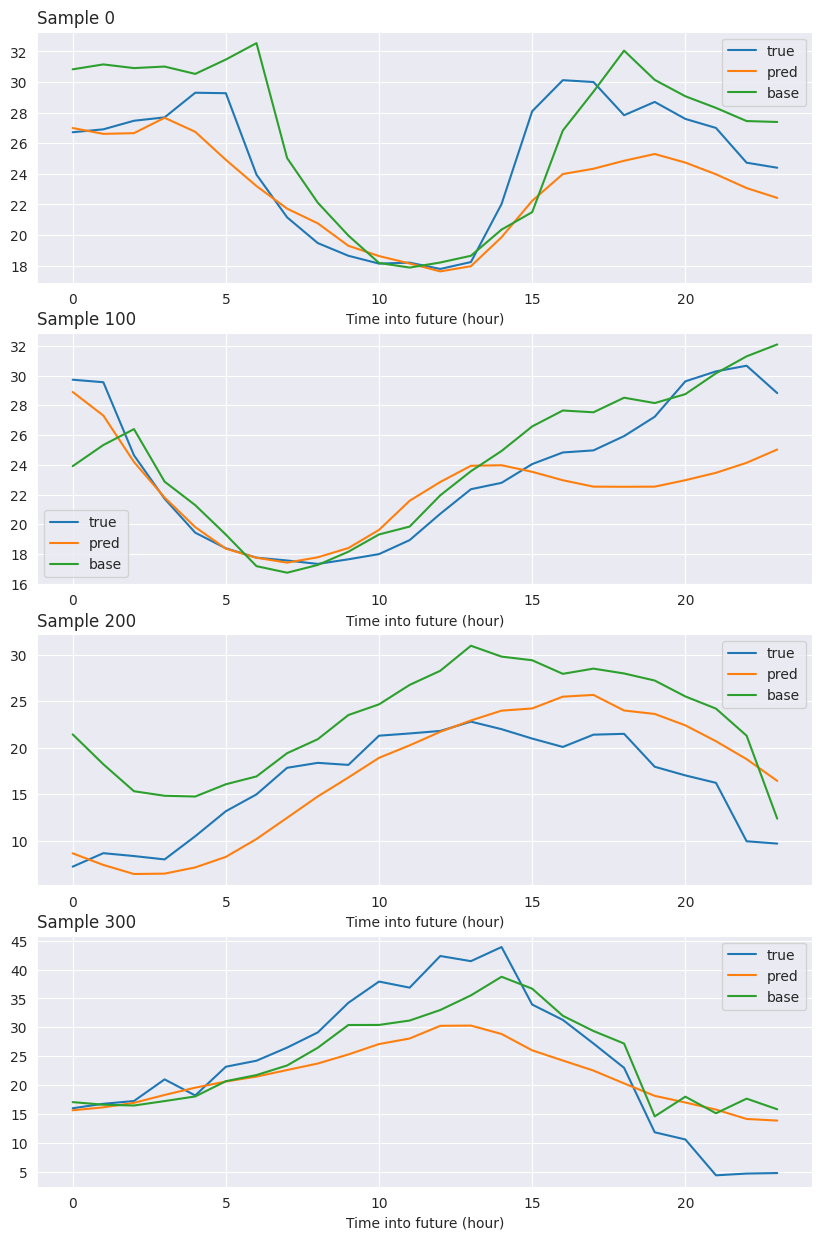

In [64]:
# sample a few plots
samples = [0, 100, 200, 300]

plt.figure(figsize=(10, 15))
for i, sample in enumerate(samples):
    plt.subplot(len(samples), 1, i+1)
    plt.plot(y_test.iloc[sample, :].values, label='true')
    plt.plot(y_test_pred.iloc[sample, :].values, label='pred')
    plt.plot(y_test_pred_base.iloc[sample, :].values, label='base')
    plt.legend()
    plt.xlabel("Time into future (hour)")
    plt.xticks()
    plt.title(f"Sample {sample}", loc='left')